In [138]:
## populating the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
import csv
from sklearn import cross_validation
from itertools import product
from itertools import combinations
from sklearn import preprocessing
from pandas.tools.plotting import scatter_matrix
from sklearn import grid_search

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Loading Data

In [139]:
# Loading the data into a DataFrame
train_df = pd.read_csv('train.csv', header=0)        # Load the train file into a dataframe
test_df = pd.read_csv('test.csv', header=0)        # Load the test file into a dataframe

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


# Feature Engineering

In [140]:
## feature engineering: extracting the title from name as it might contain useful information and making it a new feature
train_df['Title']=train_df['Name'].apply(lambda x:x.split(',')[1].split(' ')[1])
test_df['Title']=test_df['Name'].apply(lambda x:x.split(',')[1].split(' ')[1])
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,Mr.


In [141]:
# creating the feature vs target DataFrames
X_features = train_df.ix[:, ~train_df.columns.isin(['Survived'])]
y_target = train_df['Survived']

# Data Cleaning

In [142]:
# checking for NaN value in the target column
if (y_target.notnull().all()==True):
    print "There are no NaN in the target variable"
else:
    print "Target variable has NaN values that need to be removed"

There are no NaN in the target variable


In [143]:
def data_prep (X_features):
    # determining the non-numeric columns and transforming them into numeric using LabelEncoder() method
    real_or_str=X_features.applymap(np.isreal).all(0)
    non_num_feature=real_or_str[~real_or_str].keys()
    le = preprocessing.LabelEncoder()
    for col in non_num_feature:
        #2- fill the NaN in non-numeric columns with the most used element#
        X_features.ix[:,col]=X_features.ix[:,col].fillna(X_features.ix[:,col].describe().top)
        #transform the non-numeric columns to numeric values using 
        #LabelEncoder method from SKLearn#
        X_features.ix[:,col]=le.fit_transform(X_features.ix[:,col])

    # filling in NaN values with the mean value of the feature 
    X_features.ix[:,'Age'] = X_features.ix[:,'Age'].fillna(X_features.ix[:,'Age'].mean())
    X_features = X_features.fillna(X_features.mean())
    # normalizing the data (only applicable columns)
    X_features[['Age','Fare','Cabin','Title','Name','Ticket']] = \
                                preprocessing.scale(X_features[['Age','Fare','Cabin','Title','Name','Ticket']])
    return X_features

X_features_preped=data_prep(X_features)
X_features_preped.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,-1.310217,1,-0.592481,1,0,0.918966,-0.502445,-0.142511,2,0.414641
1,2,1,-0.991410,0,0.638789,1,0,1.282625,0.786845,0.719326,0,0.961158
2,3,3,-0.357685,0,-0.284663,0,0,1.646283,-0.488854,-0.142511,2,-1.224909
3,4,1,-0.672604,0,0.407926,1,0,-1.442322,0.420730,-0.525550,2,0.961158
4,5,3,-1.671790,1,0.407926,0,0,0.664904,-0.486337,-0.142511,2,0.414641


## Feature Importance Analysis

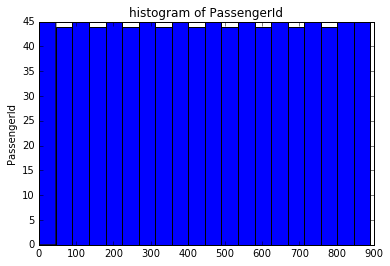

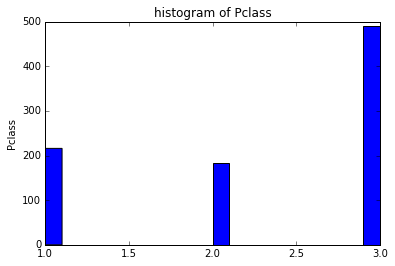

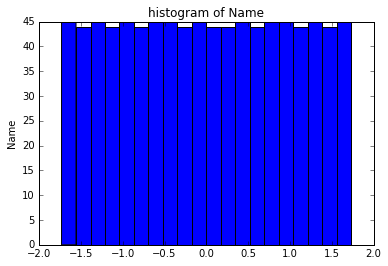

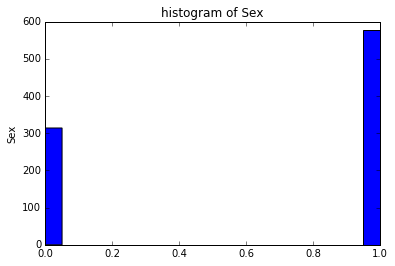

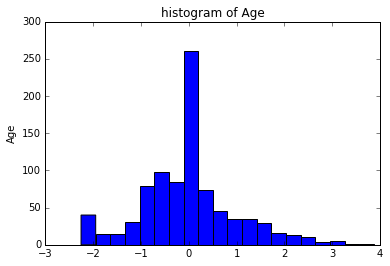

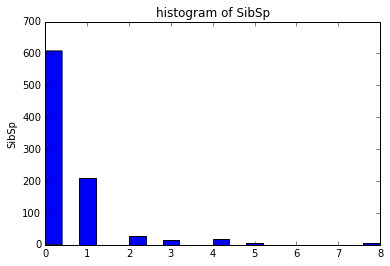

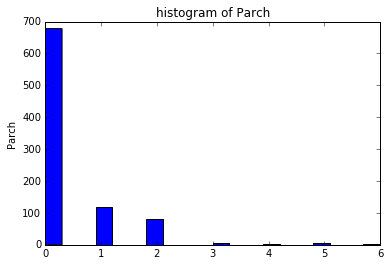

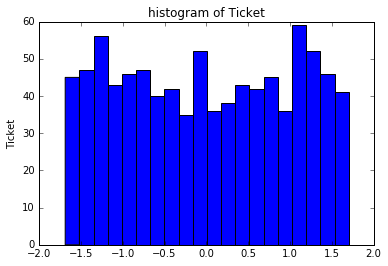

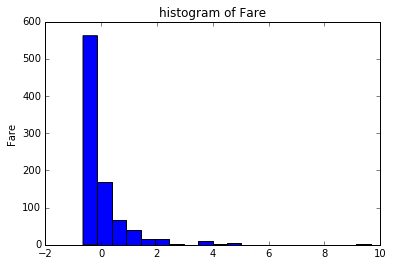

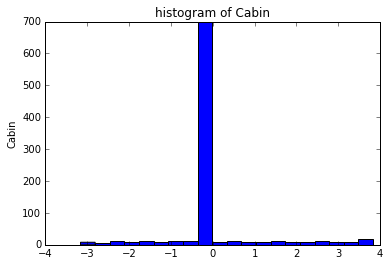

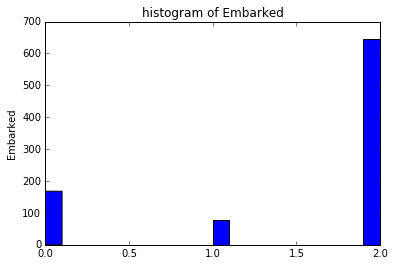

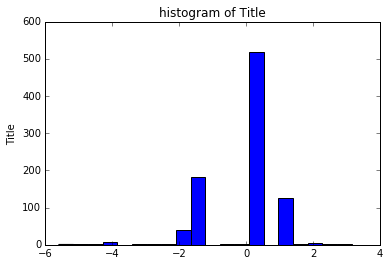

In [144]:
# plotting the histogram of all features to see which one can potentially yields useful information
for feat in X_features_preped.columns:
    plt.hist(X_features_preped[feat], bins=20)
    plt.ylabel(feat)
    plt.title("histogram of "+str(feat))
    plt.show()
    

In [145]:
# checking the number of unique elements of Name and Ticket columns to see if they yield any useful information
print "shape of train_Df= ", train_df.shape
print "number of unique elements of Name column= ", train_df['Name'].unique().shape
print "number of unique elements of Ticket column= ", train_df['Ticket'].unique().shape
print "number of unique elements of PassengerID column= ", train_df['PassengerId'].unique().shape

shape of train_Df=  (891, 13)
number of unique elements of Name column=  (891,)
number of unique elements of Ticket column=  (681,)
number of unique elements of PassengerID column=  (891,)


In [146]:
# Based on the number of unique elements, PassengerId, Name, and Ticket doesn't seem to be yielding
#any useful infor and are almost unique for each passenger and hence we will drop them
X_features_filtered = X_features_preped.drop(['PassengerId','Name','Ticket'], 1)
X_features_filtered.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,3,1,-0.592481,1,0,-0.502445,-0.142511,2,0.414641
1,1,0,0.638789,1,0,0.786845,0.719326,0,0.961158
2,3,0,-0.284663,0,0,-0.488854,-0.142511,2,-1.224909
3,1,0,0.407926,1,0,0.420730,-0.525550,2,0.961158
4,3,1,0.407926,0,0,-0.486337,-0.142511,2,0.414641


# Fitting different models, finding the best parameters and evaluating their performance

In [163]:
## function to perform grid search and find the best score and best parameters ##
def grid_searcher(reg,parameters):
    clf_DTC = grid_search.GridSearchCV(reg, parameters, cv=10)
    clf_DTC.fit(X_features_filtered,y_target)
    print "The best selected parameters for Decision Tree Regressor are: ", clf_DTC.best_params_
    print "The best score using the best selected parameters for Decision Tree Regressor is: ", clf_DTC.best_score_
    return clf_DTC.best_params_, clf_DTC.grid_scores_

In [164]:
## grid search over different parameters of Decision Tree Classifier
DTC = DecisionTreeClassifier(random_state = 1)
parameters = {'max_depth':range(1,15),'min_samples_split':range(1,10), 'min_samples_leaf':range(1,10)}
DTC_best_params, DTC_score_grid = grid_searcher(DTC,parameters)

The best selected parameters for Decision Tree Regressor are:  {'min_samples_split': 1, 'max_depth': 10, 'min_samples_leaf': 7}
The best score using the best selected parameters for Decision Tree Regressor is:  0.829405162738


In [152]:
## grid search over different parameters of Random forest Classifier
rfc = RandomForestClassifier(random_state= 1, warm_start=True)
parameters={'n_estimators':range(1,200,100),'max_depth':range(1,15,2),'min_samples_split':range(1,10,2),'max_features':range(1,10,2)}
rfc_best_params, rfc_score_grid = grid_searcher(rfc,parameters)

The best selected parameters for Decision Tree Regressor are:  {'max_features': 7, 'min_samples_split': 1, 'n_estimators': 101, 'max_depth': 7}
The best score using the best selected parameters for Decision Tree Regressor is:  0.846240179574


In [154]:
## grid search over different parameters of Gradient Boosting Classifier
GBC = ensemble.GradientBoostingClassifier(random_state=1)
parameters={'n_estimators':range(1,200,100),'max_depth':range(1,15,2),'min_samples_split':range(1,10,2),'max_features':range(1,10,2)}
GBC_best_params, GBC_score_grid = grid_searcher(GBC,parameters)

The best selected parameters for Decision Tree Regressor are:  {'max_features': 5, 'min_samples_split': 3, 'n_estimators': 50, 'max_depth': 5}
The best score using the best selected parameters for Decision Tree Regressor is:  0.845117845118


# Discussion of the results of the classifiers:
We can see that after fine tuning each classifier using grid search, ensemble learning methods (both Random Forest and Gradient Boosting) are outperforming the decision tree classifiers

## Evaluating the impact of changing different parameters on the performance of the decision tree classifier:

The best selected parameters for Decision Tree Regressor are:  {'max_depth': 7}
The best score using the best selected parameters for Decision Tree Regressor is:  0.818181818182


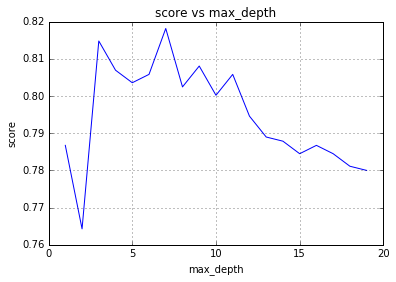

The best selected parameters for Decision Tree Regressor are:  {'min_samples_split': 13}
The best score using the best selected parameters for Decision Tree Regressor is:  0.814814814815


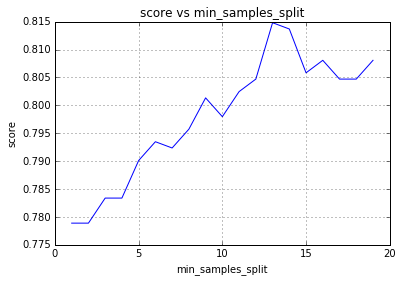

The best selected parameters for Decision Tree Regressor are:  {'min_samples_leaf': 7}
The best score using the best selected parameters for Decision Tree Regressor is:  0.829405162738


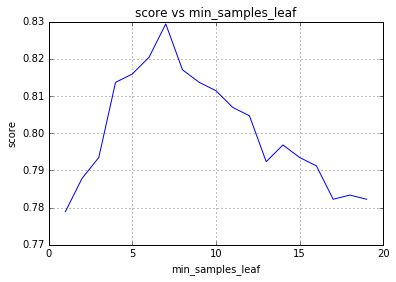

In [191]:
## to study the effect of each parameter on the performance of the regressor we need to sweep each parameter seperately
## I evaluate the effect of changing different parameters of decision tree
for param in ['max_depth','min_samples_split','min_samples_leaf']:

    parameters = {param:range(1,20)}
    DTC_best_params, DTC_score_grid = grid_searcher(DTC,parameters)

    plt.plot([ele[0][param] for ele in DTC_score_grid], [ele[1] for ele in DTC_score_grid])
    plt.xlabel(param)
    plt.ylabel('score')
    plt.title('score vs '+str(param))
    plt.grid()
    plt.show()

# Discussion of the results:
- increasing max_depth will improve the performance of the decision tree classifier up to value 7 and after this value it hurts the performance.
- increasing min_samples_split will improve the performance of the decision tree classifier up to value 13 and after some value it hurts the performance.
- increasing min_samples_leaf will improve the performance of the decision tree classifier up to value 7 and after some value it hurts the performance.

# Plotting the decision boundaries for Random Forest Regressor

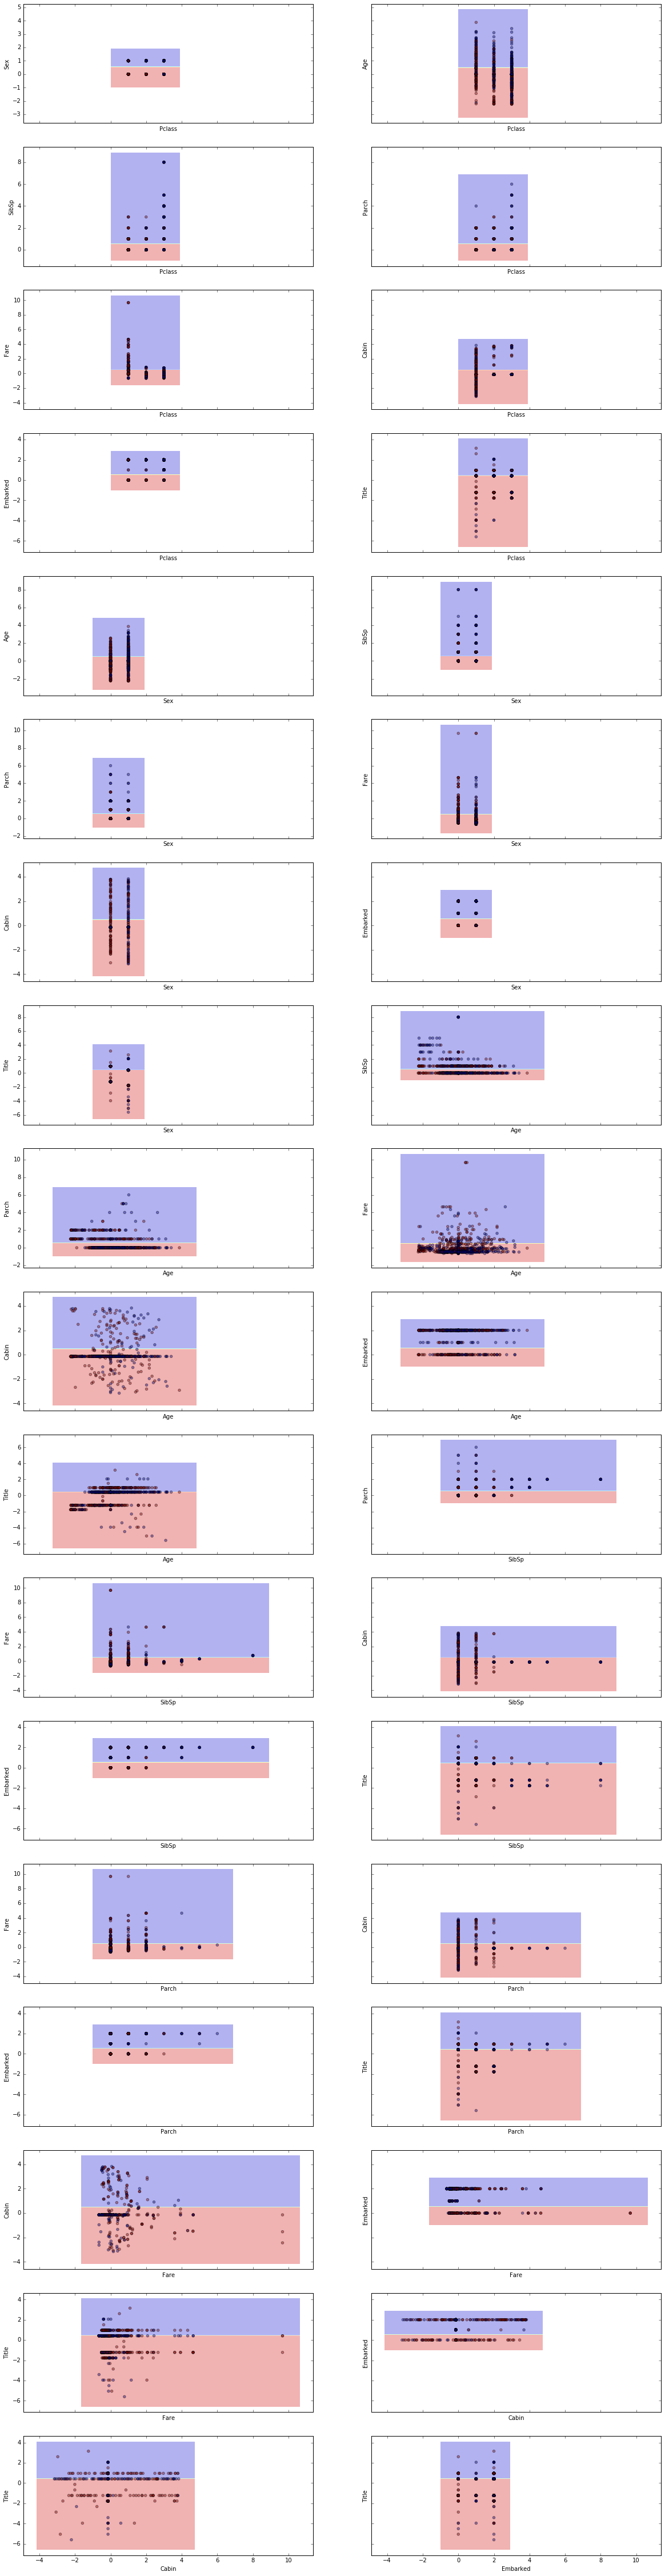

In [205]:
## ploting the decision surfaces for Random Forest Regressor for all possible pair of features for the best possible parameters:
#{'max_features': 7, 'min_samples_split': 1, 'n_estimators': 101, 'max_depth': 7}##
from itertools import product

feat_pair_len=len([c for c in combinations(X_features_filtered.columns,2)])
y = y_target
f, axarr = plt.subplots(18, 2, sharex='col', sharey='row', figsize=(20, 80))
rfc = RandomForestClassifier(n_estimators=101, max_depth=7, min_samples_split=1, random_state=0, warm_start=True)

for idx, feat_pair in zip(product([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],[0,1]), combinations(X_features_filtered.columns,2)):
    
    X = X_features_filtered[list(feat_pair)]
    rfc.fit(X, y)
    x_min, x_max = X.ix[:, 0].min() - 1, X.ix[:, 0].max() + 1
    y_min, y_max = X.ix[:, 1].min() - 1, X.ix[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))


    Z = rfc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X.ix[:, 0], X.ix[:, 1], c=y, alpha=0.4)
    axarr[idx[0], idx[1]].set_xlabel(feat_pair[0])
    axarr[idx[0], idx[1]].set_ylabel(feat_pair[1])

plt.show()

# Discussion of the results
- we can see that for some of the feature pairs (cabin, title) we have a good split and decision boundary but for most of the others we don't have a clear and reasonable boundary. This basically means that we definitely need more than two features to be able to classify this data set. And based on the good scoring results that we got, we can know that the decision boundary in 9-dimensional space (between all 9 features) are good and reasonable.

# Function to produce a csv file of outputs for test data for Kaggle Submission

In [ ]:
# Function to produce the submission file to Kaggle
def produce_submission (clf, X_features_filtered, y_target, test_df, submission_name):
    clf.fit(X_features_filtered, y_target)
    test_df_preped=data_prep(test_df)
    test_df_filtered = test_df_preped.drop(['PassengerId','Name','Ticket'], 1)
    output=clf.predict(test_df_filtered)
    ids=test_df['PassengerId']
    predictions_file = open("./Submissions/"+submission_name, "wb")
    open_file_object = csv.writer(predictions_file)
    open_file_object.writerow(["PassengerId","Survived"])
    open_file_object.writerows(zip(ids, output))
    predictions_file.close()

produce_submission(rfc, X_features_filtered, y_target, test_df, "PeymanRFC.csv")